## Homework 04: A Plague of Sand Mice
##### By Kevin Liu

Before we begin, we will first load in any necessary modules we expect to use
for this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Testing Moriarty's method

To evaluate Moriarty's classifier, we will attempt to test Moriarty's method of
scoring for each of the RNA-seq reads using the read sequences we have obtained
from sand mouse and the pathogen of interest. We will first read in each of the
fasta files and score them according to the description given by Moriarty; then,
we will calculate the true positive rate and the false positive rate using a 
series of generated threshold values; lastly, we will use the calculated values
to plot the ROC plot alongside with a histogram of the respective score
distributions for the sand mouse and pathogen reads.

Before we begin, we will take a look at how the data is encoded to help us 
understand how to read in these files. We will then define a series of functions 
to accomplish this process as many of the functions will be useful in subsequent 
analyses.

In [2]:
! head sandmouse.fa

>sandmouse.1
AAATTATTATTAACATATTTATTGACTCCTTGCATAAACAGATTACCCAATATAAAATTAATTAAAGATCAATAATGAGCAAGACTATATTGTGGTTTTTTTCTTTAATATTTTATTCTATCGTATATAAGATTAAATAATAAATAAGTAGATATAAAGATATTTTGCTATAGACTTGACCGATATTATTATCTTTTTTT
>sandmouse.2
AAACAATTTAAATTATAATAAGATCATGTAGATTTTAATATCAATCTTGAATGTAAGTTTTTGGTTTAATTATGGATTTGATGTAATATAAATGGTGAATAATGCAAGATCAGCATATAATTTTTATTTGATAAAAACTTTTAAAAATTATAGTATATACCCTATTTTTTGAATAATATGTTAAGGGATATATATATAAA
>sandmouse.3
ATTAGAGGATTAAGATATTTCAAATTTAATTAAATTGAATATTTAAATAGTTATTATTTTAATTACACAGTAGAAAATAATTAATACCCATTTTTTATAAAAATATATCTAGTTTAGAAGACATTTCACTAAAAAAATTACTACTCTTCTAAAACTGTGTAACTTTATTAAACACTTGTAATGATATAATACTATATTAA
>sandmouse.4
CGAATACTTTAAATAAATTAACATATAATTGTACGAAACACGAAATTATAACGATAATCATCCTGAGGTGAAATCTAGTTCCTAGAAAGCTTTATCTTGGGTAATATGTTCAGATTAATATAGTTTAATTAACATTTACATTATATTTGTGTTACAGTCTCTTTGTCTATTGAATACATTGTCTGAATAACGGAAGATTA
>sandmouse.5
AGAATCATTATATAACATCATACGAAATTTCAAAACTTTAAATAGAAGAAACTTTAAATTTAATCAGTTCCTGCCTAATAAATATACTTTTTTTATCACATTAAAATTTATCGAATATTTATCAACATATA

In [3]:
def read_fasta(filename):
    """
    Read in .fa format files containing sequence reads. Read names and
    sequences will be read in with the read name as the dict key and the
    sequence as the dict value with each nt as an element in a list.

    input:  filename: path for .fa fasta format file.
    output: dict with read name as key and list of nt as values.
    """
    # read in the read ids by reading in the first line and skipping every
    # other line that contains the read sequences. The read id header > and new
    # line characters \n will be stripped away. Append this to an ordered list 
    # to be merged with the sequences as a dict in subsequent steps.
    read_id = []
    with open(filename, 'r') as f:
        for count, line in enumerate(f, start = 0):
            if count % 2 == 0:
                line = line.rstrip('\n').lstrip('>')
                read_id.append(line)
    
    # read in each of the read sequences starting at the second line of the
    # fasta file, skipping every other line that contains the read ids, similar 
    # to the code chunk above. 
    read_seq = []
    with open(filename, 'r') as f:
        for count, line in enumerate(f, start = 1):
            if count % 2 == 0:
                line = line.rstrip('\n').lstrip('>')
                read_seq.append(line)
    
    # merge the two lists corresponding to the read ids and the read sequences
    # read in in previous steps and store them as a dict.
    read_data = {}
    for i in range(len(read_id)):
        read_data[read_id[i]] = list(read_seq[i])
    
    return read_data


def m_score(df):
    """
    Calculate the scores for each read according to Moriarty's method: we will
    score each A and T with a value of +1 and each G and C with a value of -1.

    input:  df: PANDAS df with reads as columns and nt as rows (i.e., wide data 
            format).
    output: list of scores based on Moriarty's classifier per read.
    """
    # pivot data from wide to long format for easy score calculation.
    l_df = df.reset_index().melt(id_vars = "index", var_name = "read", value_name = "nt")
    
    # calculate scores according to Moriarty's method.
    l_df.loc[l_df["nt"] == "A", "nt"] = 1
    l_df.loc[l_df["nt"] == "T", "nt"] = 1
    l_df.loc[l_df["nt"] == "G", "nt"] = -1
    l_df.loc[l_df["nt"] == "C", "nt"] = -1
    
    # pivot data from long to wide format, sum by each column to obtain the
    # total scores for each read sequence, and convert into a list.
    score_lst = l_df.pivot(index = "index", columns = "read").sum(axis = 0).to_list()
    
    return score_lst


def gen_thresholds(lst1, lst2, n_threshold = 100):
    """
    Generate a number of threshold values to evaluate the true positive rates
    and false positive rates for each calculated score for a read sequence.

    input:  lst1, lst2: two lists with numerical values corresponding to the
                        calculated scores per read for each dataset that we
                        intend to compare.
            n_threshold: number of threshold values to generate between global 
                         maximum and global minimum. default is 100 values.
    output: np.ndarray of threshold values.
    """
    # calculate the global maximum and global minimum between the two calculated
    # sets scores.
    glob_min = min(min(lst1), min(lst2))
    glob_max = max(max(lst1), max(lst2))
    
    # generate a 1-D array of a number of threshold values.
    threshold_arr = np.linspace(glob_min, glob_max, num = n_threshold)
    
    return threshold_arr


def get_roc(lst0, lst1, n_threshold = 100):
    """
    Calculate the true positive rates and false positive rates given two lists
    of calculated scores for each read sequence per dataset using an array of
    threshold values.

    input:  lst0, lst1: two lists with numerical values.
            n_threshold: number of threshold values to generate between global 
                         maximum and global minimum.
    output: two lists of true positive and false positive rate values.
    """
    # generate the threashold values using the gen_thresholds() function.
    thresholds = gen_thresholds(lst0, lst1, n_threshold = n_threshold)

    # calculate the true positive and false posisitive rates for each given
    # threshold value.
    tpr_lst = []
    fpr_lst = []
    for value in thresholds:
        temp_tp_lst = []
        temp_fp_lst = []
        
        # append a value of 1 to the list if a score is larger than the
        # threshold value, denoting a true positive; otherwise append a value of 
        # 0, denoting a false positive.
        for score in lst0:
            if score >= value: 
                temp_tp_lst.append(1)
            elif score < value: 
                temp_tp_lst.append(0)

        # calculate the true positive rate by getting the ratio between the 
        # number of true positives and the total number of comparisons made.
        tpr_lst.append(sum(temp_tp_lst)/len(lst0))

        # append a value of 1 to the list if a score is larger than or equal to 
        # the threshold value, denoting a false positive; otherwise append a 
        # value of 0, denoting a true positive. 
        for score in lst1:
            if score >= value:
                temp_fp_lst.append(1)
            elif score < value:
                temp_fp_lst.append(0)
        
        # calculate the false positive rate by getting the ratio between the 
        # number of false positives and the total number of comparisons made. 
        fpr_lst.append(sum(temp_fp_lst)/len(lst1))
        
    return tpr_lst, fpr_lst, thresholds


def mk_plt(score0, score1, label0, label1, classifier_label = "", return_params = False, n_threshold = 100):
    """
    Make a side-by-side plot of the score distributions for two supplied lists
    of scores according to a given algorithm as a histogram and a ROC plot of
    the classification performance.

    input:  score0, score1:   lists of calculated scores according to a
                              given classifier.
            label0, label1:   labels of the respective scores.
            classifier_label: label of the classifier used.
            return_params:    if true, return the lists of true positive rate, 
                              false positive rate, and threshold values.
    output: plot of histogram and ROC plot.
    """
    # make two subplots.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

    # get the bin edges.
    bins = np.histogram(np.hstack((score0, score1)), bins = 40)[1]
    
    # plot histogram of the two distributions.
    ax1.hist(score0, bins = bins, alpha = 0.5, density = True, label = label0, edgecolor = "black")
    ax1.hist(score1, bins = bins, alpha = 0.5, density = True, label = label1, edgecolor = "black")
    ax1.set_xlabel("Score")
    ax1.set_ylabel("Frequency")
    ax1.legend()

    # generate a number of thresholds for score evaluation and calculate the 
    # true positive and false positive rates.
    tpr_lst, fpr_lst, thresholds = get_roc(score0, score1, n_threshold = n_threshold)
    
    # plot ROC.
    ax2.plot(fpr_lst, tpr_lst, label = classifier_label)
    ax2.plot([0, 1], [0, 1], transform = ax2.transAxes, color = "black", ls = ":", label = "Random classifier")
    ax2.set_title("ROC Plot")
    ax2.set_xlabel("False Positives")
    ax2.set_ylabel("True Positives")
    ax2.legend()
    
    if return_params == True:
        return tpr_lst, fpr_lst, thresholds

After defining the above functions, we can begin to evaluate Moriarty's
classifier by first reading in the datasets, calculating the scores based on
Moriarty's method for each read per dataset, and plotting the results.

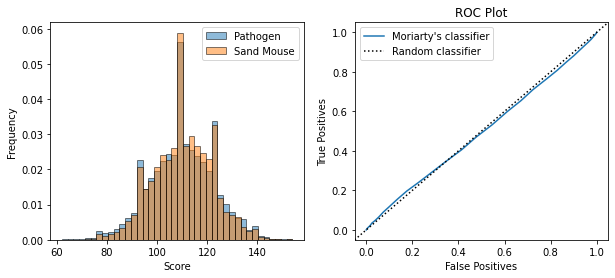

In [4]:
# read in each of the fasta files, convert them into PANDAS dfs, and score them
# using Moriarty's method.
neg_df = pd.DataFrame(read_fasta('moriarty-neg.fa'))
m_neg_scores = m_score(neg_df)

path_df = pd.DataFrame(read_fasta('pathogen.fa'))
m_path_scores = m_score(path_df)

sm_df = pd.DataFrame(read_fasta('sandmouse.fa'))
m_sm_scores = m_score(sm_df)

# evaluate the model performance and plot the score distribution histogram and 
# ROC plot.
mk_plt(m_path_scores, m_sm_scores, label0 = "Pathogen", label1 = "Sand Mouse", classifier_label = "Moriarty's classifier")

After examining the above plots, it is apparent that Moriarty's method does not 
perform well in the classification of pathogen and sand mouse sequences. This is
particularly apparent by inspecting the ROC plot, we see that Moriarty's method 
performs no better than a classification by random chance, which is represented
as a black dotted diagonal line. Looking at the histogram, we see that the score
distributions between pathogen and sand mouse almost perfectly overlap, which 
again suggests that Moriarty's scoring method cannot distinguish between the
two distributions.

The poor performance of Moriarty's classifier is expected as Moriarty's scoring 
method assumes that the occurrence of each base on a genetic sequence follows a
uniform random distribution, which does not apply for real genetic sequences;
this also explains why Moriarty's method works well for the classification of 
random sequences and the pathogen sequences, as the random sequences are
generated such that each of the four bases have an equal probability of occuring.

#### 2. Making my own method

Given the poor performance of Moriarty's classification method, we will implement our own method for discriminating pathogen sequences against the sandmouse sequences using a second order Markov model, which assumes that each nucleotide from a read sequence is dependent on the two nucleotides preceding it. In other words, the probability of occurrence for a given nucleotide within a read sequence is given by $P(x_i|x_{i-1}, x_{i-2})$.

To implement this, we will define a series of functions to estimate all relevant probabilities as well as functions to assist in the evaluation of our model's classification performance as shown below.

In [5]:
def df_to_lst(df):
    """
    Converts a PANDAS df object to a list of lists with each read belonging to a 
    nested list for convenience of further data manipulation.

    input:  df: PANDAS df with columns as reads and rows as nucleotides.
    output: list of lists with each nested list corresponding to a read.
    """
    # transpose the df such that each row is a read, convert the row into a 
    # list, then append to a list.
    read_lst = []
    for i in range(len(df.T)):
        read_i = df.T.iloc[i].to_list()
        read_lst.append(read_i)
    
    return read_lst


def train_test_split(read_lst, split_val = 0.5):
    """
    Given a list of lists containing sequence reads from a single dataset, split 
    the data into two lists (train and test sets) by a user supplied proportion.

    input:  read_lst:  list of data to be shuffled and split into training and 
                       testing sets.
            split_val: proportion of data to be sampled into the training set.
    output: two lists of training data and test data.
    """
    # randomly shuffle the list of read sequences.
    np.random.shuffle(read_lst)
    
    # determine the index to split the list according to the user supplied 
    # proportion for train/test splitting.
    i = int(len(read_lst)*split_val)
    
    # split the data by the split index generated above.
    train_lst = read_lst[:i]
    test_lst = read_lst[i:]
    
    return train_lst, test_lst


def get_nt_triplets(read_lst):
    """
    Given a list of lists containing sequence reads from a dataset, get every 
    three-mer (i.e., triplets) starting at the third position for a sequence and 
    store them in as separate lists according to the third nucleotide letter.

    input:  read_lst: list of lists containing sequence reads.
    output: list of lists each corresponding to a triplet category.
    """
    # for each sequence read, get all possible triplets starting from the third 
    # position and store them in a list.
    triplets = []
    for read in read_lst:
        for i in range(2, len(read)):
            triplets.append(read[i-2:i+1])

    # categorize each of the triplets by the third nucleotide letter and store 
    # them in their respective lists.
    A_lst = []
    T_lst = []
    G_lst = []
    C_lst = []
    for elem in triplets:
        if elem[2] == "A":
            A_lst.append(''.join(elem))
        elif elem[2] == "T":
            T_lst.append(''.join(elem))
        elif elem[2] == "G":
            G_lst.append(''.join(elem))
        elif elem[2] == "C":
            C_lst.append(''.join(elem))
    
    return [A_lst, T_lst, G_lst, C_lst]


def get_cond_prob(triplet_lst):
    """
    Calculates the conditional probability for a particular nucleotide to occur 
    given the probability of the two preceding nucleotides occurring.

    input:  triplet_lst: a list of lists containing all possible triplets 
                         categorized by the nucleotide letter at the third 
                         position.
    output: a dict of conditional probabilities for each triplet occurring given 
            the probability of the two preceding nucleotide combination 
            occurring.
    """
    # get the total number of possible triplets based on read sequences within a 
    # list of reads.
    total_triplet_count = sum([len(i) for i in triplet_lst])

    # for a given list of triplets categorized by the nucleotide letter at the 
    # third position, calculate the probability that the triplet occurs among 
    # all possible triplets.
    triplet_prob = {}
    for nt_triplet in triplet_lst:
        unique_triplets, unique_counts = np.unique(nt_triplet, return_counts = True)
        unique_prob = unique_counts/total_triplet_count
        for i in range(len(unique_triplets)):
            triplet_prob[unique_triplets[i]] = unique_prob[i]

    # generate all 16 combinations of dinucleotide pairs.
    nt_lst = list("ATGC")
    dnt_lst = [x + y for x in nt_lst for y in nt_lst]

    # calculate the conditional probability that the third letter of the triplet 
    # occurs given that the two preceding nucleotides occur.
    cond_prob = {}
    dnt_matches = {}
    for dnt in dnt_lst:
        # for each triplet, get the probability of the triplet occurring for a 
        # given combination of the two preceding nucleotides.
        for triplet, prob in triplet_prob.items():
            if triplet[0:2] == dnt:
                dnt_matches[triplet] = prob
        
        # get the total probability of all triplets with the same two preceding 
        # nucleotides occurring.
        total_prob = sum(dnt_matches.values())

        # calculate the conditional probability for a given nucleotide to occur 
        # at the third position of the triplet given the probability of the two 
        # preceding nucleotides occurring.
        for triplet, prob in dnt_matches.items():
            cond_prob[triplet] = prob/total_prob
    
    return cond_prob


def get_init_prob(read_lst):
    """
    Calculates the probability estimates of how likely a dinucleotide 
    combination occurs at the initial two nucleotide letters in a list of 
    sequence reads.
    
    input:  read_lst: list of lists containing sequence reads.
    output: dict of probability estimates of the occurrence for the initial two 
            nucleotides in a read sequence.
    """
    # generate all 16 combinations of dinucleotide pairs.
    nt_lst = list("ATGC")
    dnt_lst = [x + y for x in nt_lst for y in nt_lst]

    # for each unique dinucleotide combination, calculate the probability that 
    # the dinucleotide combination occurs at the first two base positions for a 
    # given list of read sequences and store them by the dinucleotide 
    # combination as a dict.
    init_prob = {}
    for dnt in dnt_lst:
        # count the number of times a dinucleotide combination is found within a 
        # list of read sequences as the first two nucleotides.
        seq_count = 0
        for read in read_lst:
            if ''.join(read[0:2]) == dnt:
                seq_count += 1
                
        # calculate the probability of each dinucleotide combination occurring 
        # at the first two nucleotides within a read sequence for a list of 
        # reads.
        init_prob[dnt] = seq_count/len(read_lst)
    
    return init_prob


def get_llr(read_lst, init_prob_dict0, cond_prob_dict0, init_prob_dict1, cond_prob_dict1):
    """
    Calculates the log likelihood ratios for a list of read sequences based on 
    probabilities from two distributions.
    
    input:  read_lst:                         a list of read sequences from a 
                                              particular dataset.
            init_prob_dict0, init_prob_dict1: dict of probabilities for how 
                                              likely a dinucleotide combination 
                                              occurs at the initial two 
                                              nucleotide letters in a list of 
                                              sequence reads.
            cond_prob_dict0, cond_prob_dict1: dict of conditional probabilities 
                                              for a particular nucleotide to 
                                              occur given the probability of the 
                                              two preceding nucleotides occur.
    output: a list of log likelihood ratios for a user supplied list of read 
            sequences and dicts of probabilities from the two distributions to 
            be tested.
    """
    # calculate the log likelihood ratios for each sequence in the list of 
    # reads.
    llr = []
    for read in read_lst:
        # concatenate the list of nucleotides for a read sequence into a single 
        # string.
        read_str = ''.join(read)
        
        # get the probability of the first two nucleotides for this read occurring 
        # at the first two positions and append it to a list.
        log_prob_lst0 = []
        log_prob_lst1 = []
        log_prob_lst0.append(np.log2(init_prob_dict0[read_str[0:2]]))
        log_prob_lst1.append(np.log2(init_prob_dict1[read_str[0:2]]))
        
        # for every triplet in the read sequence, calculate the log probability that 
        # the triplet occurs.
        for i in range(len(read_str[2:])):
            triplet = read_str[i:i+3]
            log_prob_lst0.append(np.log2(cond_prob_dict0[triplet]))
            log_prob_lst1.append(np.log2(cond_prob_dict1[triplet]))
        
        # calculate the log likelihood ratio for a read sequence and append it 
        # to a list.
        llr.append(sum(log_prob_lst0) - sum(log_prob_lst1))

    return llr

After implementing all necessary functions to construct and evaluate our model, we will train the model after splitting the pathogen and sandmouse datasets into their respective training and testing sets and evaluate our classification performance by determining the number of true positives and false positives resulting from our log likelihood ratio scores using a number of threshold values.

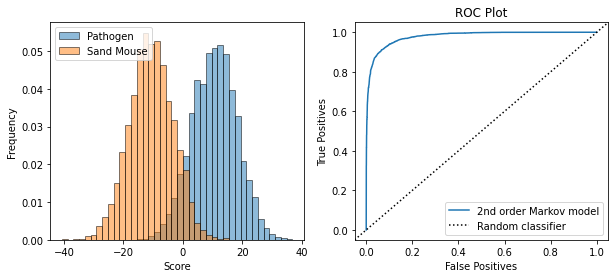

In [6]:
# set a random seed to ensure results are reproducible from the train/test 
# split.
np.random.seed(123)

# convert each dataset from a df to a list of lists containing read sequences.
path_lst = df_to_lst(path_df)
sm_lst = df_to_lst(sm_df)

# split each dataset into training and testing sets with equal proportions.
path_train, path_test = train_test_split(path_lst)
sm_train, sm_test = train_test_split(sm_lst)

# train our model with the pathogen training dataset and calculate relevant 
# parameters.
path_triplets = get_nt_triplets(path_train)
path_cond_prob = get_cond_prob(path_triplets)
path_init_prob = get_init_prob(path_train)

# train our model with the sandmouse training dataset and calculate relevant 
# parameters.
sm_triplets = get_nt_triplets(sm_train)
sm_cond_prob = get_cond_prob(sm_triplets)
sm_init_prob = get_init_prob(sm_train)

# calculate the log likelihood ratios for each of the testing datasets based on 
# the parameters calculated using our training datasets.
path_llr = get_llr(path_test, path_init_prob, path_cond_prob, sm_init_prob, sm_cond_prob)
sm_llr = get_llr(sm_test, path_init_prob, path_cond_prob, sm_init_prob, sm_cond_prob)

# evaluate our model performance by plotting a histogram of score distributions
# and ROC plot.
eval_tpr_lst, eval_fpr_lst, eval_thresholds = mk_plt(path_llr, sm_llr, label0 = "Pathogen", label1 = "Sand Mouse", classifier_label = "2nd order Markov model", return_params = True, n_threshold = 10000)

Based on the above plots, it is apparent that our second order Markov model performs fairly well in the classification of read sequences obtained from pathogen and sandmouse datasets. The improved classification performance relative to that of Moriarty's method is particularly apparent as the ROC plot shows both high sensitivity and high specificity. The histogram of the log likelihood ratio scores also demonstrate a distinguishable separation between the two frequency distributions with some amount of overlap, again suggesting an improvement in classification performance over that of Moriarty's method.

The improvement in classification performance using our second order Markov model relative to Moriarty's method is expected. Unlike Moriarty's scoring method, which assumes that the occurrence of each base on a genetic sequence follows a uniform random distribution, our model assumes that each nucleotide from a read sequence is dependent on the two nucleotides preceding it and is thus more applicable to genetic sequences that occur in nature where genetic sequences do not follow a uniform random distribution.

#### 3. Evaluating my method

To further appriase our classification method using our second order Markov model, we will assume a scenario where we need to achieve at least 90% sensitivity and report the optimal threshold and the corresponding false discovery rate at that threshold. For the calculation of the false discovery rate, we know that in an RNA-seq sample from an infected sand mouse, only 1% of the reads are from the pathogen while the remaining 99% of the reads are from the mouse. Therefore, the false discovery rate at a given threshold can be calculated using these parameters as shown below.

In [7]:
# get a list of indicies for classifications that achieve at least a 90% 
# sensitivity.
index_lst = []
for i, tpr in enumerate(eval_tpr_lst):
    if tpr >= 0.9:
        index_lst.append(i)

# get the sensitivity, false positive rate, and threshold values based on the 
# identified optimal index.
threshold = round(eval_thresholds[max(index_lst)], 4)
tpr = eval_tpr_lst[max(index_lst)]
fpr = eval_fpr_lst[max(index_lst)]

# calculate the false discovery rate.
fdr = round((fpr*0.99)/((fpr*0.99)+(tpr*0.01)), 4)

print("To achieve a sensitivity of " + str(tpr*100) + "%, we will need to set a score threshold of " + str(threshold) + ".\n" + \
      "Under this score threshold, the false discovery rate is " + str(fdr*100) + "%.")

To achieve a sensitivity of 90.0%, we will need to set a score threshold of 0.8089.
Under this score threshold, the false discovery rate is 86.53%.


Based on our evaluation of the second order Markov model for classification of sand mouse sequences against pathogen sequences, we find that our model will result in a 86.53% false discovery rate in order to achieve a 90% sensitivity. This suggests that 86.53% of the reads we identify as belonging to the pathogen are actually false positives from the sand mouse given a sensitivity of 90%, which is not ideal.